In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize
import datetime

%matplotlib inline

# Core Functions

The functions below form the core of the simulation. Note that we haven't bothered to write a function for computing magnetization, because the magnetization is just the sum of the spins on the lattice.

In [2]:
# assumes periodic BCs
def metropolis_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the Metropolis algorithm and the 
       corresponding change in energy"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # randomly choose new state
    new_state = random.randint(1,q)
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # randomly choose new state excluding current one
    states = [i for i in range(1, q+1)]
    states = np.delete(states, grid[y,x]-1)
    new_state = np.random.choice(states)
    
    # checking the energy cost
    energy_i = potts_energy_spin(grid, [y,x])
    energy_f = potts_energy_spin(grid, [y,x], new_state)
    
    d_energy = int(energy_f - energy_i)
    
    # applying the metropolis algorithm
    if d_energy <= 0:
        grid[y,x] = new_state
        
    elif random.uniform(0,1) < boltz[str(d_energy)]:
        grid[y,x] = new_state
        
    else:
        d_energy = 0
        

    return [grid, d_energy]



def met_sweep(init, q, boltz):
    """Convenience function identical to metropolis_ising, but evolves per sweep and doesn't return the energy"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            # select random spin from the input spin grid
            x = random.choice(range(X))
            y = random.choice(range(Y))
            
            # randomly choose new state excluding current one
            states = [i for i in range(1, q+1)]
            states = np.delete(states, grid[y,x]-1)
            new_state = np.random.choice(states)

            # checking the energy cost
            energy_i = potts_energy_spin(grid, [y,x])
            energy_f = potts_energy_spin(grid, [y,x], new_state)

            d_energy = int(energy_f - energy_i)

            # applying the metropolis algorithm
            if d_energy <= 0:
                grid[y,x] = new_state

            elif random.uniform(0,1) < boltz[str(d_energy)]:
                grid[y,x] = new_state


    return grid

In [3]:
# assumes periodic boundary condition
def heatbath_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the heat-bath algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    
    # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
    # we only want to compute the energies that are non-zero
    check = []
    check.append(grid[(y+1) % Y, x])
    check.append(grid[(y-1) % Y, x])
    check.append(grid[y % Y, (x+1) % X])
    check.append(grid[y % Y, (x-1) % X])
    check = list(set(check))
    
    
    # initialize the boltzmann factors to 1 because the zero energy states have boltzmann factor equal to 1
    probs = np.ones(q)
    
    # replace the appropriate elements with the boltzman factors; note that order in probs is important!
    for c in check:
        e = potts_energy_spin(grid, [y,x], c)
        probs[c-1] = boltz[str(e)]
    
    # normalize probablities
    probs = np.array(probs)/np.sum(probs)   
    
    # choose new state
    new_state = np.random.choice(range(1, q+1), p = probs)
    
    grid[y,x] = new_state
    
    return grid



def heatbath_sweep(init, q, boltz):
    """Convenience function identical to heatbath_potts, but evolves one sweep"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(Y):
        for i in range(X):
            # select random spin from the input spin grid
            x = random.choice(range(X))
            y = random.choice(range(Y))


            # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
            # we only want to compute the energies that are non-zero
            check = []
            check.append(grid[(y+1) % Y, x])
            check.append(grid[(y-1) % Y, x])
            check.append(grid[y % Y, (x+1) % X])
            check.append(grid[y % Y, (x-1) % X])
            check = list(set(check))

            # initialize the probabilities to 1 because the zero energies have boltzmann factor equal to 1
            probs = np.ones(q)

            # replace the appropriate elements with the boltzman factors; note that order in probs is important!
            for c in check:
                e = potts_energy_spin(grid, [y,x], c)
                probs[c-1] = boltz[str(e)]

            probs = np.array(probs)/np.sum(probs)   

            new_state = np.random.choice(range(1, q+1), p = probs)

            grid[y,x] = new_state
    
    return grid

        

# Measurements

In [4]:
def potts_energy_spin(init, spin, q = None):
    """Compute the energy of a spin on a Potts lattice"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    x = spin[1]
    y = spin[0]
    
    # allows you to change the value of the spin in question
    if q is not None:
        grid[y,x] = q
    
    energy = 0
    
    if grid[y, (x + 1) % X] == grid[y,x]:
        energy += -1

    if grid[y, (x - 1) % X] == grid[y,x]:
        energy += -1

    if grid[(y + 1) % Y, x] == grid[y,x]:
        energy += -1

    if grid[(y - 1) % Y, x] == grid[y,x]:
        energy += -1
    
    return energy


def potts_energy(init):
    """Computes the energy of a Potts grid by iterating over potts_energy_spin"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            spin_energy = potts_energy_spin(init, [i,j])
            energy += spin_energy
    
    # overcount every bound twice, so divide by 2
    return energy/2


def potts_mag(init, roots):
    """Computes the magnetization of a Potts grid using a list of roots of unity"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    mag = 0
    
    for i in range(Y):
        for j in range(X):
            d_mag = roots[grid[i,j]-1]
            mag += d_mag
            
    mag = abs(mag)
            
    return mag

In [7]:
def plot_potts(grid, title = '', cmap = plt.cm.coolwarm):
    """Plot a Potts grid using a color map"""
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(grid, cmap=cmap)
    plt.colorbar()
    
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Example: Equilibration Plots

In [2]:
x_values = np.arange(0, 900*1000, 100)/900

In [8]:
# initialize to a T = infinity state in the q = 10 Potts model
L = 30
initial10 = np.random.randint(1, 11, (L, L))
grid1 = copy.copy(initial10)
grid2 = copy.copy(initial10)

T = 0.4
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

In [83]:
energy_list = np.zeros(L*L*1000)
energy_list_met = np.zeros(L*L*1000)

start = time.time()
for i in range(L*L*1000):
    grid1 = heatbath_potts(grid1, 10, boltz)
    grid2 = metropolis_potts(grid2, 10, met_boltz)[0]
    
    #if ((i+1) % 100 == 0):                        # option to speed up the program by not measuring at every step
    energy_list[i] = potts_energy(grid1)
    energy_list_met[i] = potts_energy(grid1)

    if ((i+1) % (L*L*100)) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/(L*L)}; {tick-start} seconds')


# normalize
energy_list = energy_list/(L*L)
energy_list_met = energy_list_met/(L*L)



Sweep 100.0; 11.122299671173096 seconds
Sweep 200.0; 22.294695615768433 seconds
Sweep 300.0; 33.106995582580566 seconds
Sweep 400.0; 43.85283160209656 seconds
Sweep 500.0; 54.723660469055176 seconds
Sweep 600.0; 65.83107948303223 seconds
Sweep 700.0; 76.74704337120056 seconds
Sweep 800.0; 87.67094349861145 seconds
Sweep 900.0; 98.35825157165527 seconds
Sweep 1000.0; 109.07085585594177 seconds


In [113]:
# initialize to a T = infinity state in the q = 3 Potts model
initial = np.random.randint(1, 3, (L, L))
grid1 = copy.copy(initial)
grid2 = copy.copy(initial)

In [114]:
energy_listq3 = np.zeros(L*L*1000)
energy_list_metq3 = np.zeros(L*L*1000)

start = time.time()
for i in range(L*L*1000):
    grid1 = heatbath_potts(grid1, 10, boltz)
    grid2 = metropolis_potts(grid2, 10, met_boltz)[0]
    
    #if ((i+1) % 100 == 0):                        # option to speed up the program by not measuring at every step
    energy_listq3[i] = potts_energy(grid1)
    energy_list_metq3[i] = potts_energy(grid2)

    if ((i+1) % (L*L*100)) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/(L*L)}; {tick-start} seconds')


# normalize
energy_listq3 = energy_listq3/(L*L)
energy_list_metq3 = energy_list_metq3/(L*L)


Sweep 100.0; 11.096011877059937 seconds
Sweep 200.0; 21.803655862808228 seconds
Sweep 300.0; 32.45574760437012 seconds
Sweep 400.0; 43.03492784500122 seconds
Sweep 500.0; 53.67858815193176 seconds
Sweep 600.0; 64.38176846504211 seconds
Sweep 700.0; 75.44405245780945 seconds
Sweep 800.0; 86.32132840156555 seconds
Sweep 900.0; 97.03938794136047 seconds
Sweep 1000.0; 107.7460401058197 seconds


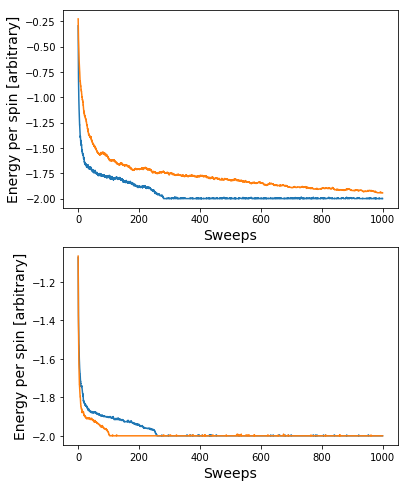

In [5]:
fig = plt.figure(figsize = (6,8))


fig.add_subplot(2, 1, 1)
plt.plot(x_values, energy_list)
plt.plot(x_values, energy_list_met)
plt.tick_params(axis='both', which='major', labelsize = 10)
plt.xlabel("Sweeps", fontsize=14)
plt.ylabel("Energy per spin [arbitrary]", fontsize=14)

fig.add_subplot(2, 1, 2)
plt.plot(x_values, energy_listq3)
plt.plot(x_values, energy_list_metq3)
plt.tick_params(axis='both', which='major', labelsize = 10)
plt.xlabel("Sweeps", fontsize=14)
plt.ylabel("Energy per spin [arbitrary]", fontsize=14)

plt.savefig('potts_equil.pdf', bbox_inches = 'tight')

# Example: Getting Data and Measurements
An example of the kind of code used to get the q = 3 Potts measurements

In [12]:
# for convenience
def round_to_3(x):
    if x != 0:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 2)
    else:
        return 0

In [13]:
# initialize to T = infinity
L = 25
initial = np.random.randint(1, 4, (L, L))

# set temperature range
temps = [i for i in np.arange(0.6, 1.41, 0.01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict = {}
mag_dict = {}


# initialize lists to plot
eneps_list = np.zeros(t_points)
magps_list = np.zeros(t_points)
spec_heat = np.zeros(t_points)
mag_sus = np.zeros(t_points)

# rough estimate for equilibration time
n_eq = 50*L

# number of sweeps to average over
n = 50*L

# set up keys and entries for dictionary
for T in temps:
    energy_dict[str(T)] = []
    mag_dict[str(T)] = []

# factors for averaging
n1 = 1/(n * L**2)
n2 = 1/(n**2 * L**2)


# roots of unity for magnetization
rou = [np.exp(2*np.pi*1j*n/3) for n in range(3)]

In [156]:
# running the program!
print(datetime.datetime.now().time())
start = time.time()

grid = copy.copy(initial)

for i in range(t_points):
    T = temps[i]
    met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = met_sweep(grid, 3, met_boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # dummy lists to hold the measurements
    e_all = np.zeros(n)
    m_all = np.zeros(n)
    
    # measurements to average
    for k in range(n):
        grid = met_sweep(grid, 3, met_boltz)
        energy = potts_energy(grid)             # only taking measurements every sweep
        mag = potts_mag(grid, rou)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
        
        e_all[k] = energy
        m_all[k] = mag
    
    
    # storing all measurements for error purposes 
    energy_dict[str(T)] = e_all
    mag_dict[str(T)] = m_all
    
    # compute averages
    eneps_list[i] = n1*e_total
    magps_list[i] = n1*mag_total
    spec_heat[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    
    # manual checkpointing
    if (0.599 < T < 0.601) or (0.799 < T < 0.801) or (0.999 < T < 1.001) or (1.199 < T < 1.201):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

22:55:54.712567
T = 0.6; 17.590633392333984 seconds
T = 0.8; 368.83340072631836 seconds
T = 1.0; 730.5144848823547 seconds
T = 1.2; 1211.1110289096832 seconds
Total time: 1660.8608484268188


Text(0,0.5,'Magnetic Susceptibility')

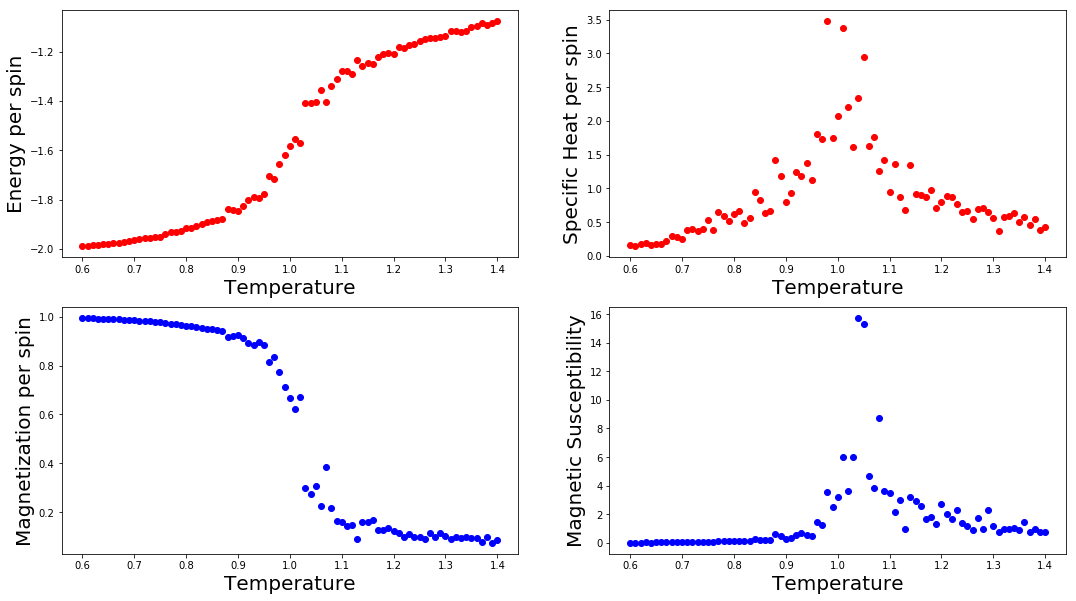

In [158]:
# plot everything
fig = plt.figure(figsize=(18, 10))  

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetic Susceptibility", fontsize=20)

## At this point, the code is exactly like in Metropolis, because the data analysis naturally doesn't change

# Example: Computing Errors
Uses the values from the run above to compute errors

In [13]:
keys = list(mag_dict.keys())

mag_errors = []

for k in keys:
    mag_errors.append(bootstrap_mean(mag_dict[k], 1000))
    
mag_errors = np.array(mag_errors)/(L*L)

################################################

sus_errors = []

for k in keys:
    sus_errors.append(bootstrap_s(mag_dict[k], float(k), L*L, 1000))
    
################################################

sh_errors = []

for k in keys:
    sh_errors.append(bootstrap_c(energy_dict[k], float(k), L*L, 1000))
    
#################################################

ene_errors = []

for k in keys:
    ene_errors.append(bootstrap_mean(energy_dict[k], 1000))
    
ene_errors = np.array(ene_errors)/(L*L)

# Example: Fitting Lines for Critical Exponents
Here I just directly show the work done to fit the curve for the magnetization on a 25 by 25 lattice with q = 3, i.e. the plot on the report. We simply repeat the same procedure for the other critical exponents.

In [10]:
temps = [i for i in np.arange(0.5, 1.51, 0.01)]

Text(0,0.5,'Magnetization')

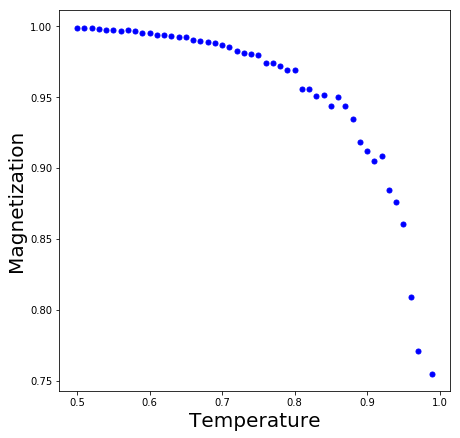

In [51]:
plt.figure(figsize=(7,7)) 
plt.plot(temps[:49], magps_list[:49], 'bo', markersize = 5)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization", fontsize=20)

In [218]:
scipy.optimize.curve_fit(power, temp_test[39:49], mag_test[39:49], p0 = [1, 1.1, 0.1], sigma = mtest_error[39:49], maxfev=10000)

C:\Users\Newton\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(array([1.14703244, 1.00305732, 0.0991277 ]),
 array([[0.00434894, 0.00065461, 0.00182483],
        [0.00065461, 0.00013336, 0.00029268],
        [0.00182483, 0.00029268, 0.00077754]]))

In [ ]:
# extended the function beyond the fit points so that it can be seen more easily against the data
f_m = [power(x,1.14703244, 1.00305732, 0.0991277) for x in temps [39:51]]

# Example: Generating the final plot

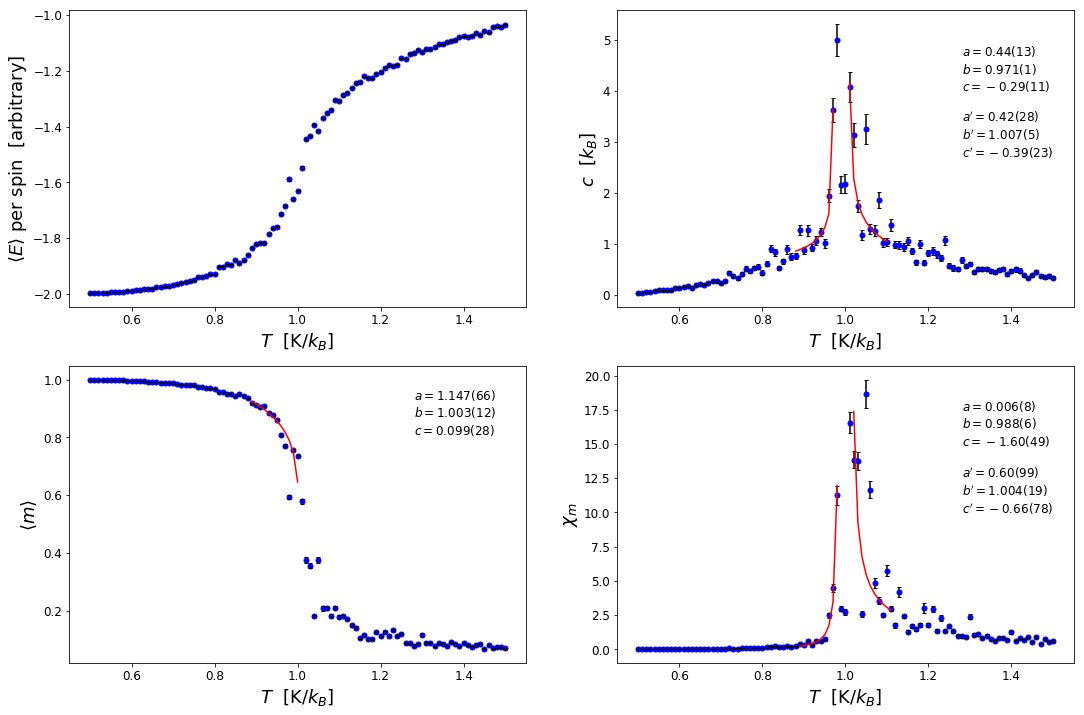

In [20]:
fig = plt.figure(figsize=(18, 12))
plt.tight_layout(pad=0, w_pad= 2, h_pad= 2)

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list, 'bo', markersize = 5)
plt.errorbar(temps, eneps_list, yerr = ene_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\langle E \rangle$ per spin  [arbitrary]", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)


fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'bo', markersize = 5)
plt.errorbar(temps, spec_heat, yerr = sh_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[38:48], f_sh, 'r')
plt.plot(temps[51:61], f_shp, 'r')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel("$c$  [$k_B$]", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(1.28, 4, r'$a = 0.44(13)$' +'\n' + r'$ b = 0.971(1)$' + '\n' + r'$c = -0.29(11)$', fontsize=12)
plt.text(1.28, 2.7, r"$a' = 0.42(28)$" +'\n' + r"$b' = 1.007(5)$" +'\n' + "$c' = -0.39(23)$", fontsize=12)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list, 'bo', markersize = 5)
plt.errorbar(temps, magps_list, yerr = mag_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[39:51], f_m, 'r')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\langle m \rangle$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(1.28, 0.81, r'$a = 1.147(66)$' +'\n' + r'$ b = 1.003(12)$' + '\n' + r'$c = 0.099(28)$', fontsize=12)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus, 'bo', markersize = 5)
plt.errorbar(temps, mag_sus, yerr = sus_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[39:49], f_sus, 'r')
plt.plot(temps[52:62], f_susp, 'r')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\chi_m$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(1.28, 14.9, r'$a = 0.006(8)$' +'\n' + r'$ b = 0.988(6)$' + '\n' + r'$c = -1.60(49)$', fontsize=12)
plt.text(1.28, 9.9, r"$a' = 0.60(99)$" +'\n' + r"$b' = 1.004(19)$" +'\n' + "$c' = -0.66(78)$", fontsize=12)


#plt.savefig('Potts Measurements.pdf', bbox_inches = 'tight')